In [27]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , Normalizer , MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import plotly.express as px
from sklearn.metrics import silhouette_samples , silhouette_score
from sklearn.cluster import DBSCAN

## Data Exploration

In [28]:
df = pd.read_csv("data.csv")
df.columns

Index(['Unnamed: 0', 'name', 'brand', '2G', '3G', '4G', '5G', 'Announced',
       'Status', 'Weight', 'Length', 'Width', 'Diameter', 'SIM',
       'Display Type', 'Display Size', 'ppi', 'body ratio', 'OS',
       'battery_capacity', 'Price', 'CPU', 'ratio', 'pixel', 'WLAN', 'Colors',
       'Sensors', 'Bluetooth', 'GPU', 'Loudspeaker', '3.5mm jack', 'Chipset',
       'Network', 'Internal', 'Card slot', 'RAM', 'Storage'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2651 non-null   int64  
 1   name              2651 non-null   object 
 2   brand             2651 non-null   object 
 3   2G                2651 non-null   bool   
 4   3G                2651 non-null   bool   
 5   4G                2651 non-null   bool   
 6   5G                2651 non-null   bool   
 7   Announced         2651 non-null   float64
 8   Status            2651 non-null   object 
 9   Weight            2651 non-null   float64
 10  Length            2651 non-null   object 
 11  Width             2651 non-null   object 
 12  Diameter          2651 non-null   object 
 13  SIM               2651 non-null   object 
 14  Display Type      2651 non-null   object 
 15  Display Size      2651 non-null   float64
 16  ppi               2651 non-null   float64


## Outlier detection

In [30]:
class OutlierDetector:
    def __init__(self, df):
        self.df = df

    def detect_and_replace(self):
        for col in self.df.columns:
            if col in ['Price' , 'battery_capacity']:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                self.df[col] = np.where(self.df[col] < lower_bound, lower_bound, self.df[col])
                self.df[col] = np.where(self.df[col] > upper_bound, upper_bound, self.df[col])
        return self.df

In [31]:
outlier_detector = OutlierDetector(df)
df = outlier_detector.detect_and_replace()

## Scaling

In [32]:
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]

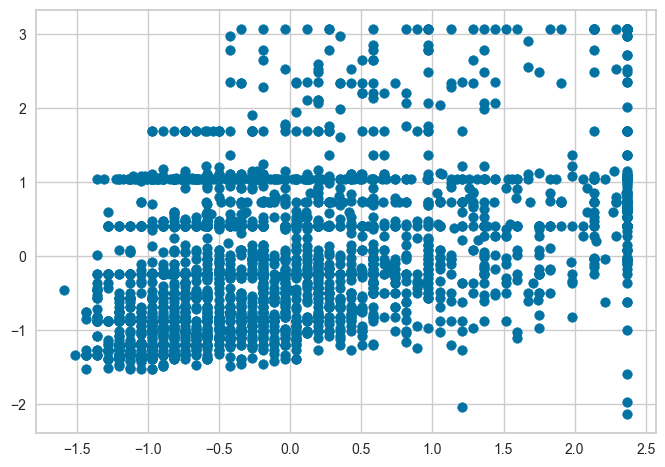

In [33]:
scaler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])

## Clustering with K-means, n_clusters=5

In [34]:
kmeans = KMeans(n_clusters=5 , random_state=42)
kmeans.fit(df[['Price_scaled' , 'battery_capacity_scaled']])

KMeans(n_clusters=5, random_state=42)

In [35]:
df['kmeans_5'] = kmeans.labels_

In [36]:
df['kmeans_5'].unique()

array([0, 2, 4, 3, 1])

In [37]:
kmeans.cluster_centers_

array([[-0.47857844,  0.05522759],
       [ 1.9545787 ,  1.14595739],
       [-0.73235776, -0.99381167],
       [-0.2458256 ,  1.24321012],
       [ 0.70360675, -0.32715986]])

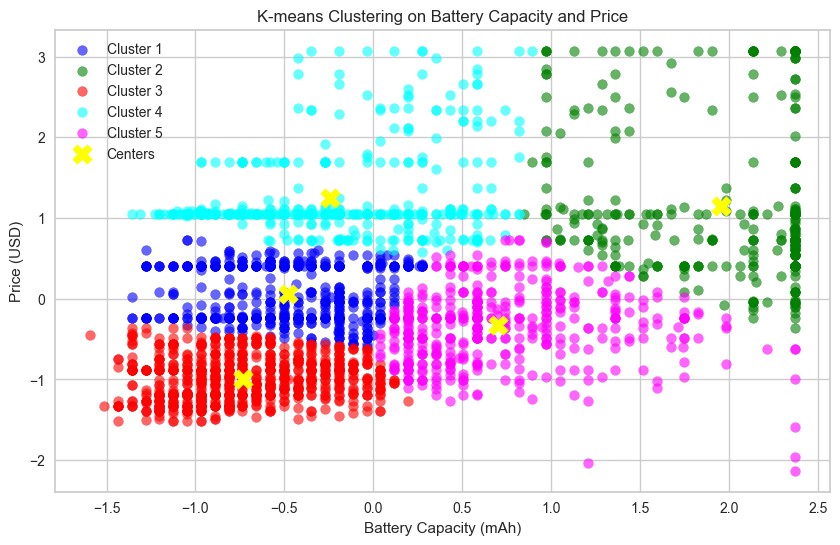

In [38]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i in range(5):
    # Plot points belonging to the current cluster
    cluster_data = df[df['kmeans_5'] == i]
    plt.scatter(cluster_data['Price_scaled'], cluster_data['battery_capacity_scaled'], color=colors[i], label=f'Cluster {i+1}', alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, color='yellow', marker='X', label='Centers')

plt.title('K-means Clustering on Battery Capacity and Price')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Elbow Plot


In [39]:
def optimise_k_means(data , max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,7))
    plt.plot(means , inertias , 'o-')
    plt.xlabel('Number of Clusters(K)') 
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()   

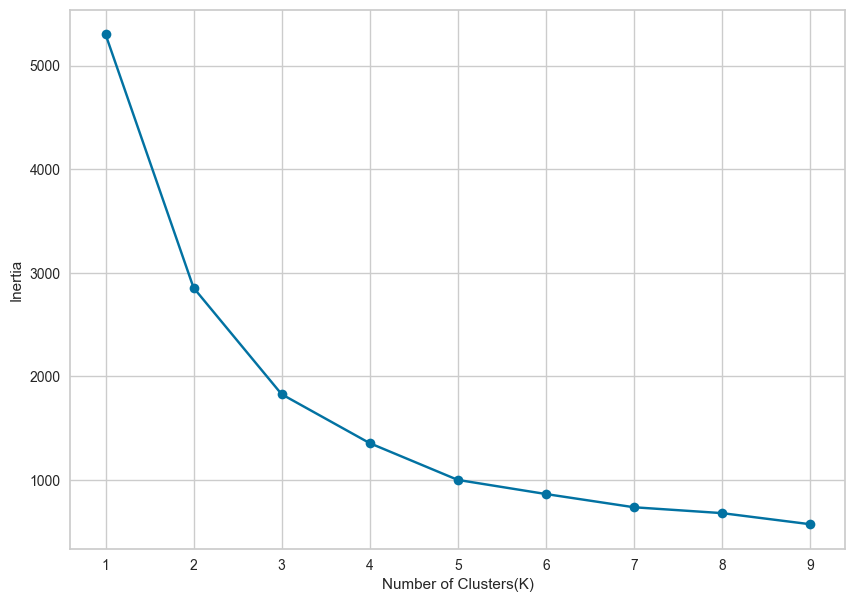

In [40]:
optimise_k_means(df[['Price_scaled' , 'battery_capacity_scaled']] , 10)

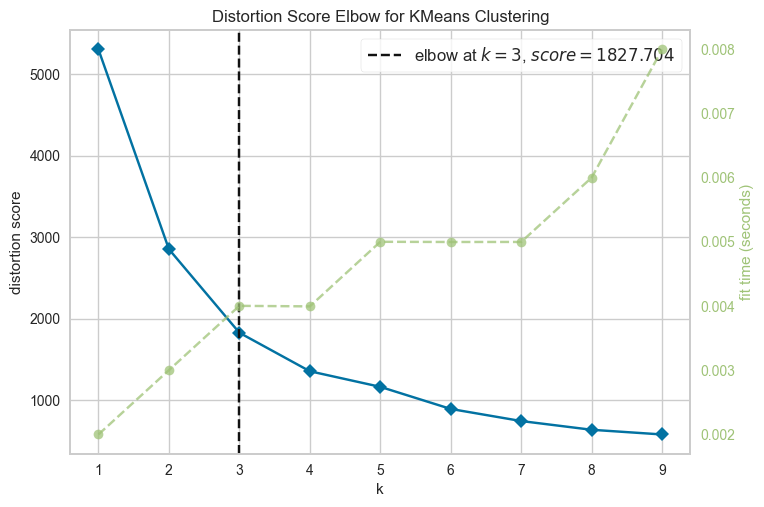

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10))
 
visualizer.fit(df[['battery_capacity_scaled' , 'Price_scaled']])        # Fit the data to the visualizer
visualizer.show()

## Checking Silhouette Scores

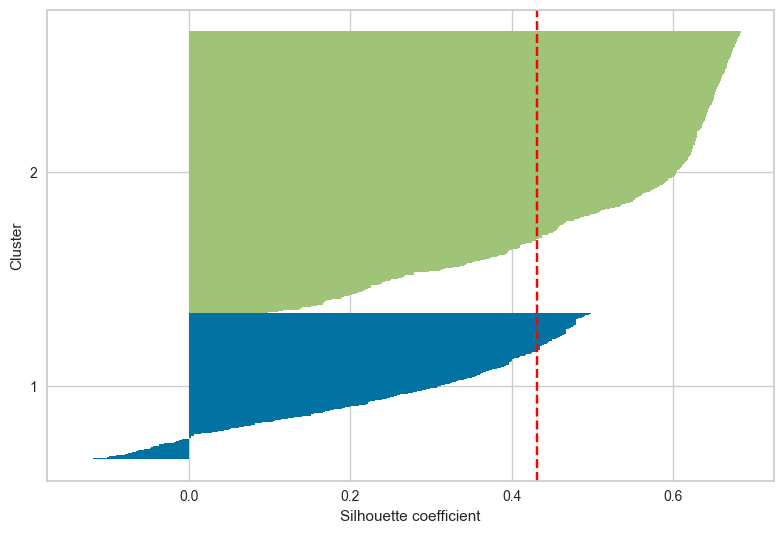

0.43213758331890284


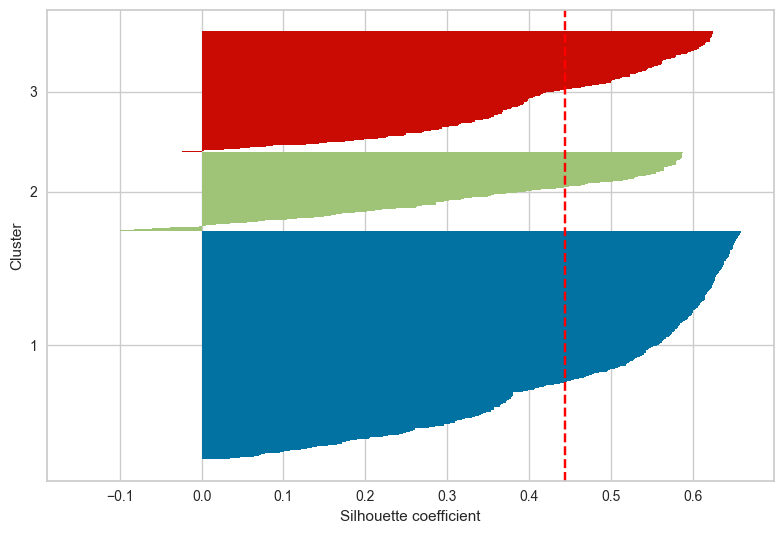

0.4441339538376631


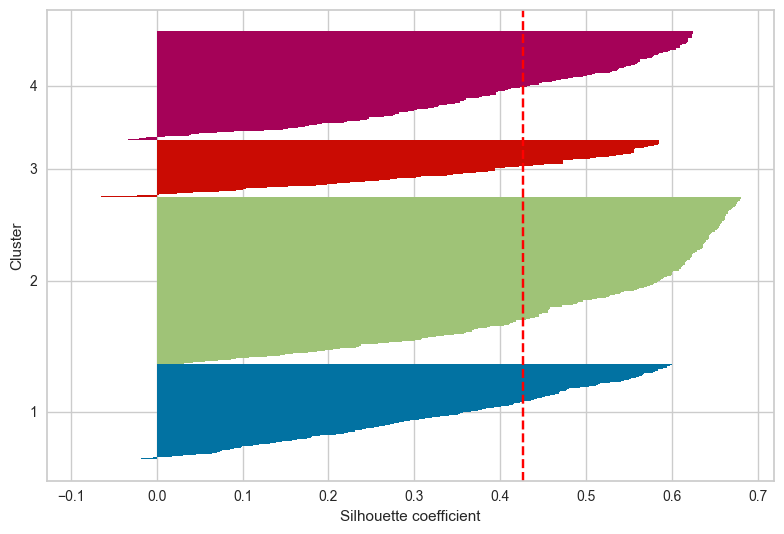

0.4264122837509147


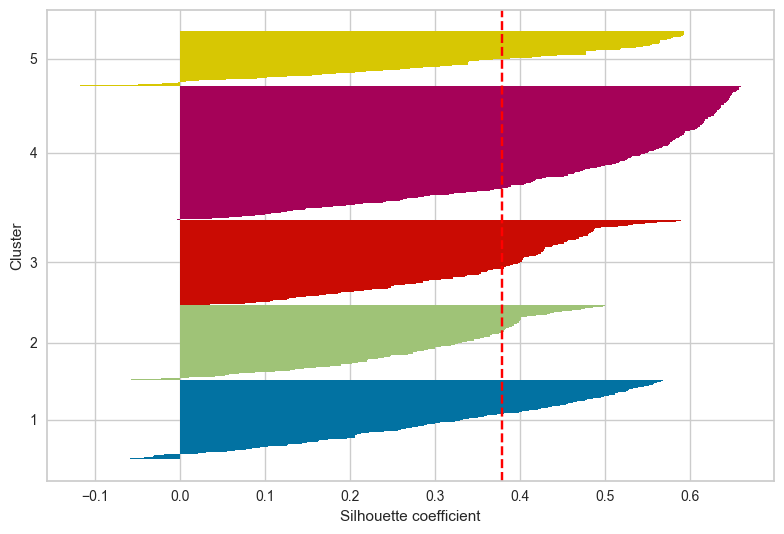

0.3786011394763808


In [42]:
for k in range(2, 6):
    km = KMeans(n_clusters=k)
    X = df[['Price_scaled' , 'battery_capacity_scaled']]
    y_km = km.fit(X)
    y_km = km.labels_
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                edgecolor='none')

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
        
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()
    print(silhouette_score(X, y_km))

## Chossing n_clusters=3 based on Elbow plot and Silhouette Scores

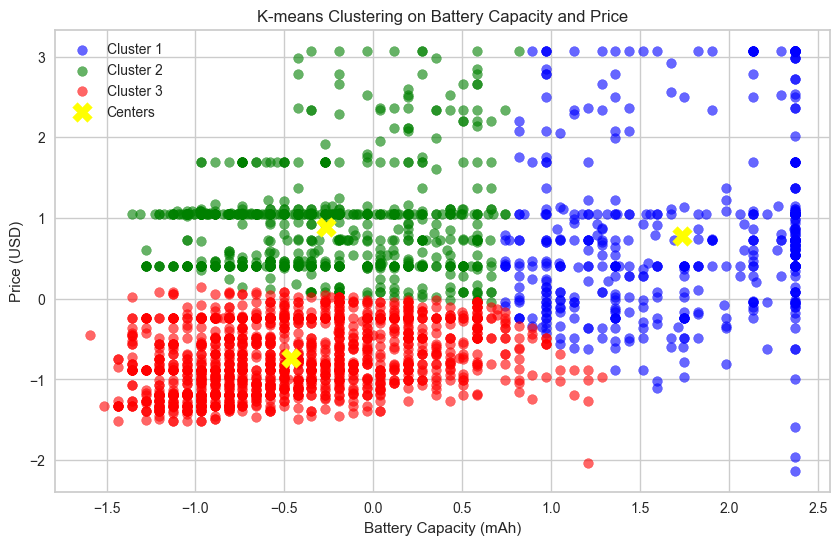

In [43]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['Price_scaled' , 'battery_capacity_scaled']])
df['kmeans_3'] = kmeans.labels_
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i in range(3):
    # Plot points belonging to the current cluster
    cluster_data = df[df['kmeans_3'] == i]
    plt.scatter(cluster_data['Price_scaled'], cluster_data['battery_capacity_scaled'], color=colors[i], label=f'Cluster {i+1}', alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, color='yellow', marker='X', label='Centers')

plt.title('K-means Clustering on Battery Capacity and Price')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Price (USD)')
plt.legend()
# plt.grid(True)
plt.show()


## DBSCAN

## Without droping outliers

In [47]:
df = pd.read_csv("data.csv")
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]
caler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])

In [48]:
dbscan = DBSCAN(eps=0.6, min_samples=30)

In [49]:
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
np.unique(labels)

array([-1,  0], dtype=int64)

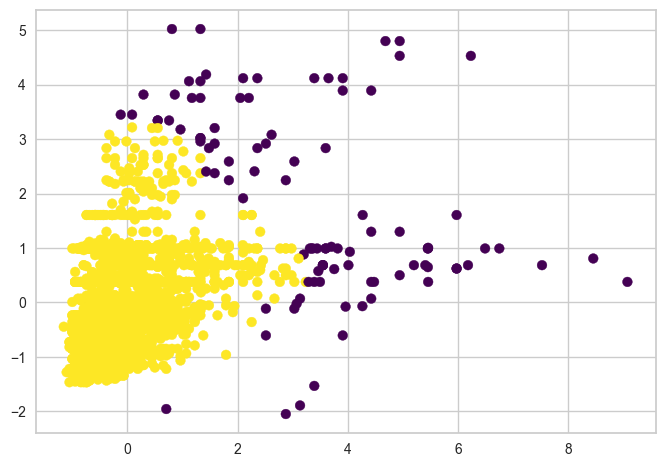

In [50]:
plt.scatter(df["Price_scaled"] , df["battery_capacity_scaled"], c=labels, cmap='viridis')

## Searching in hyperparameters to find possible models that produce three clusters 

In [51]:
list_minpt = []
list_eps = []
for eps in np.arange(0.1,5,0.1).astype(float): 
    for minpt in range (5,60,5):
        dbscan = DBSCAN(eps=eps, min_samples=minpt)
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        list_labels = list(np.unique(labels))
        if len(list_labels) == 3:
            list_eps.append(eps)
            list_minpt.append(minpt)

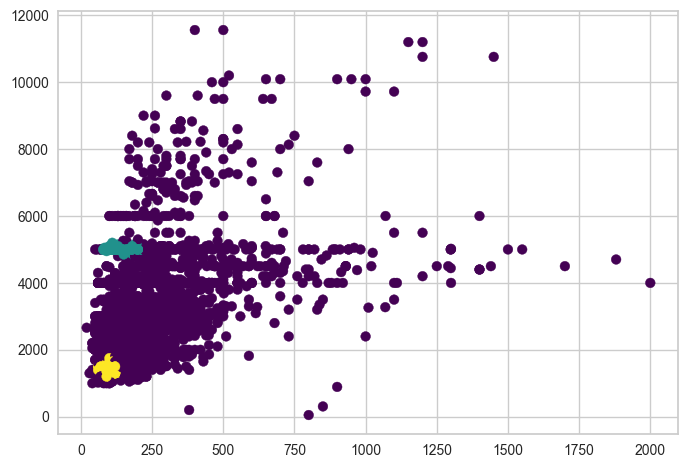

eps= 0.1 min_samples= 55
-0.1460582443946223


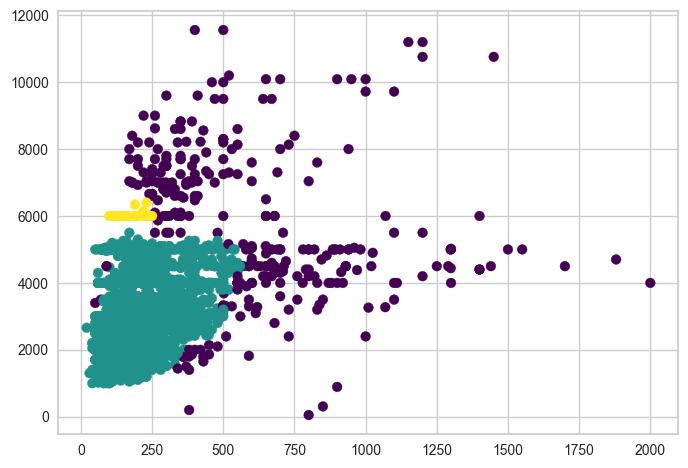

eps= 0.2 min_samples= 15
0.3224754773477632


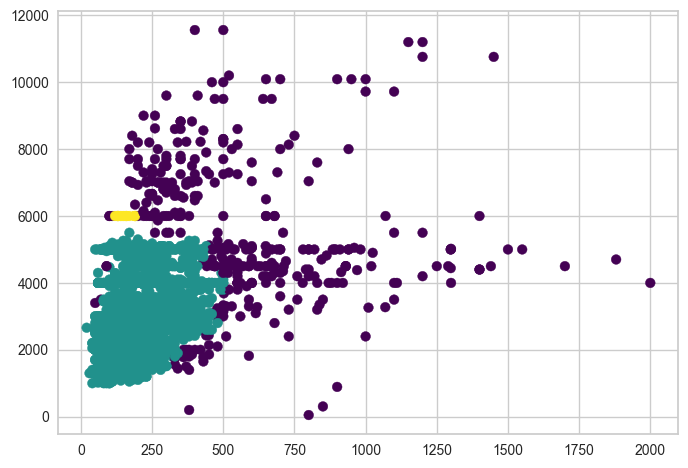

eps= 0.2 min_samples= 20
0.29439439703002274


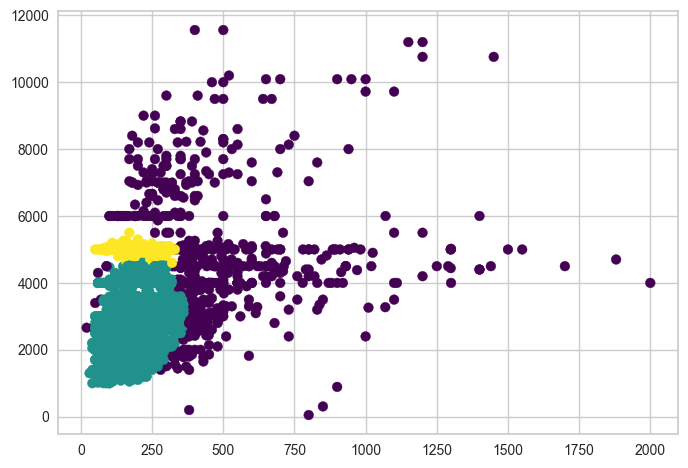

eps= 0.2 min_samples= 40
0.3107745295048545


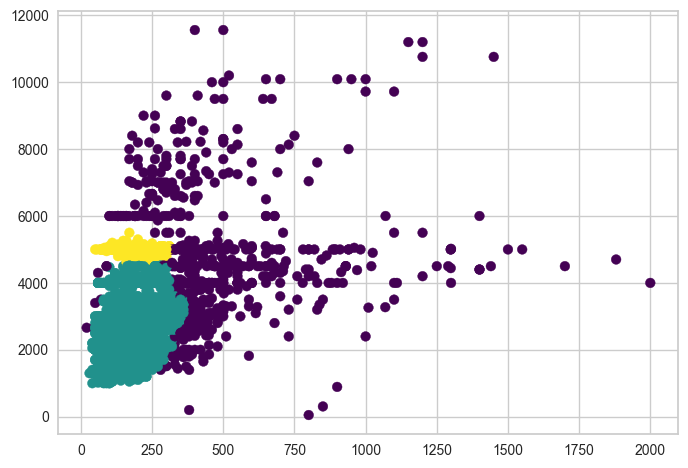

eps= 0.2 min_samples= 45
0.3059720108313492


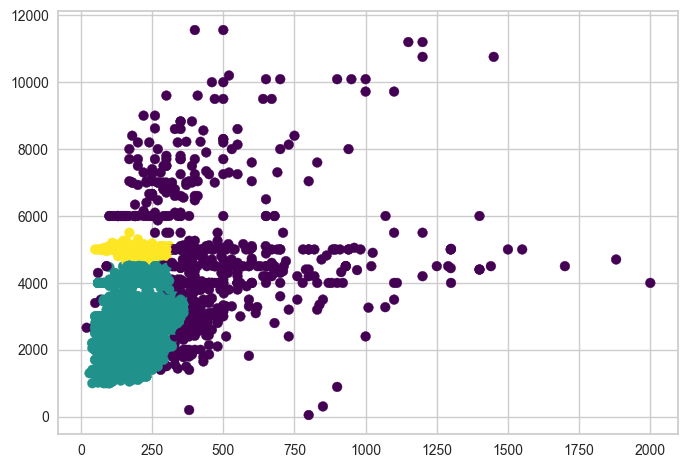

eps= 0.2 min_samples= 50
0.3051304802242596


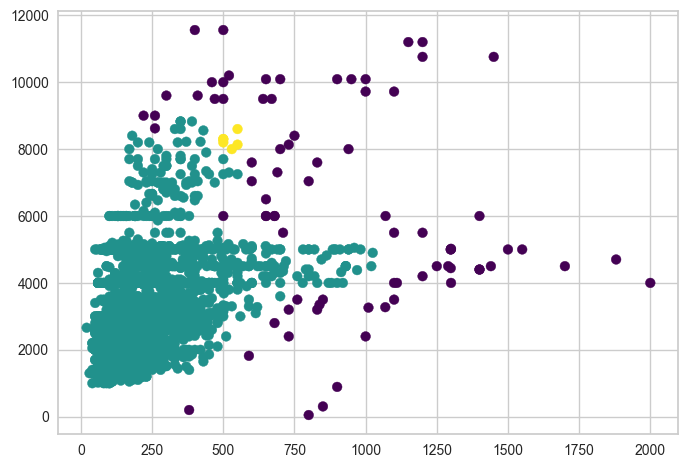

eps= 0.30000000000000004 min_samples= 5
0.5081203695973623


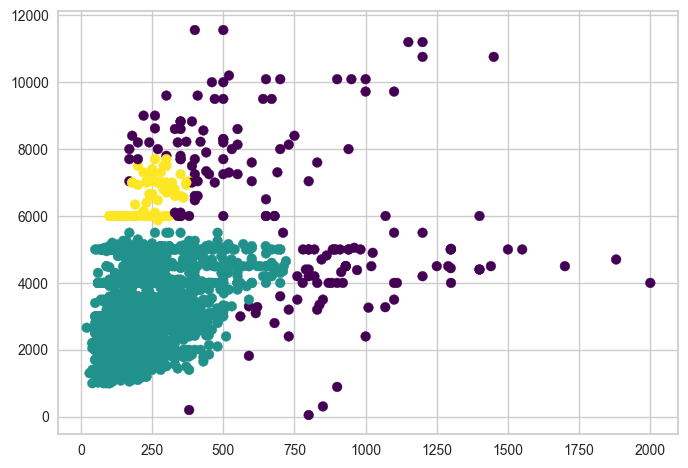

eps= 0.30000000000000004 min_samples= 15
0.44703557252253423


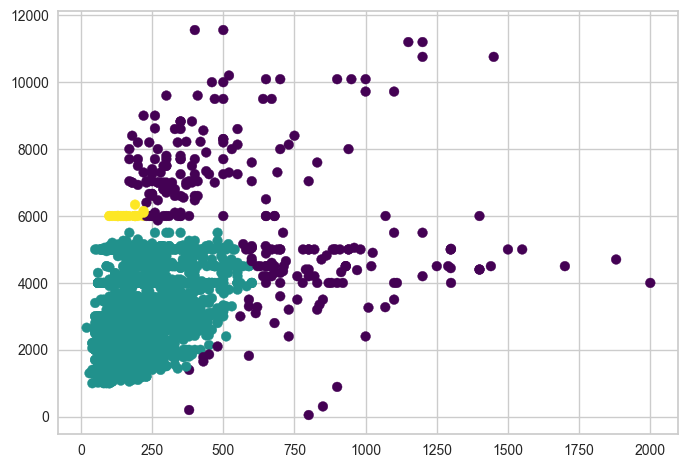

eps= 0.30000000000000004 min_samples= 25
0.3362795606393983


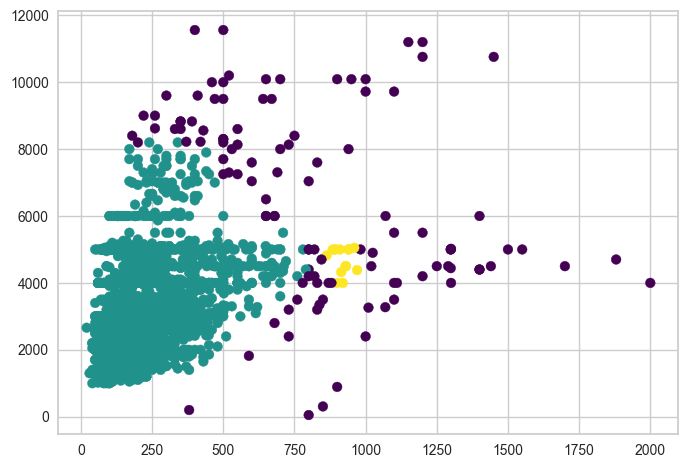

eps= 0.4 min_samples= 15
0.07439169209737596


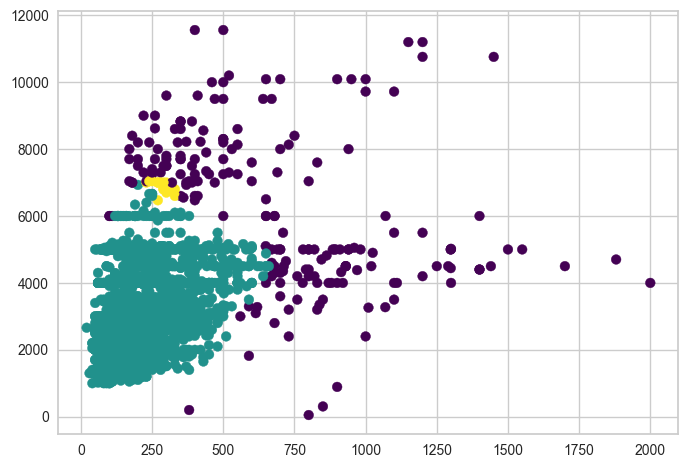

eps= 0.4 min_samples= 35
0.4325649411145207


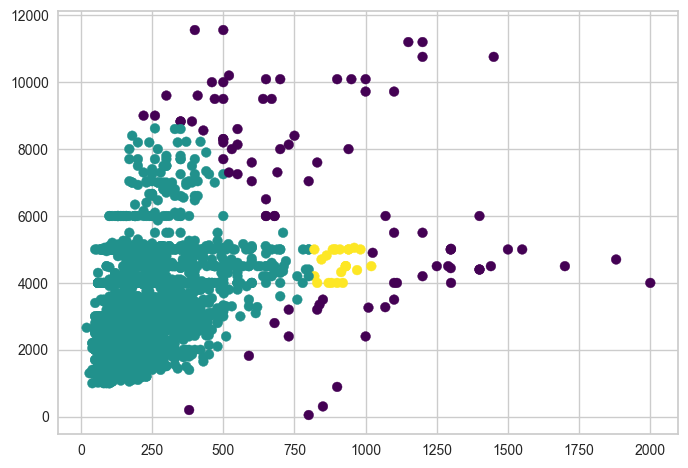

eps= 0.5 min_samples= 20
0.0572004122841773


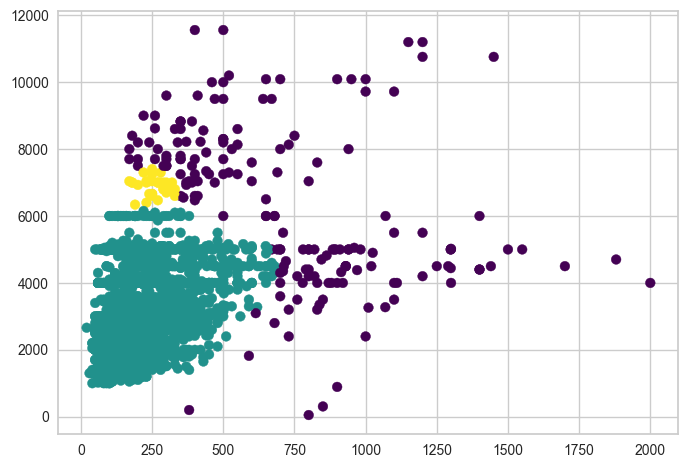

eps= 0.5 min_samples= 50
0.4560803318970681


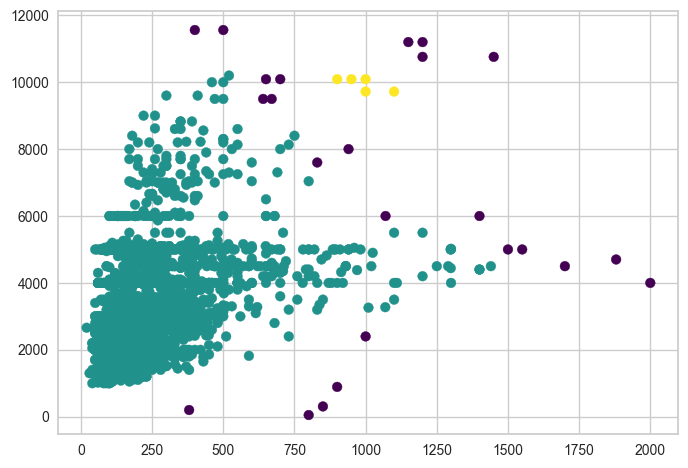

eps= 0.6 min_samples= 5
0.6043679392511306


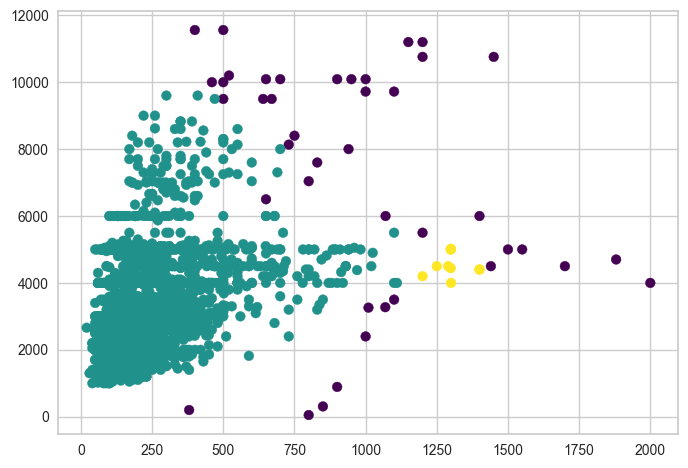

eps= 0.6 min_samples= 10
0.11944788441858929


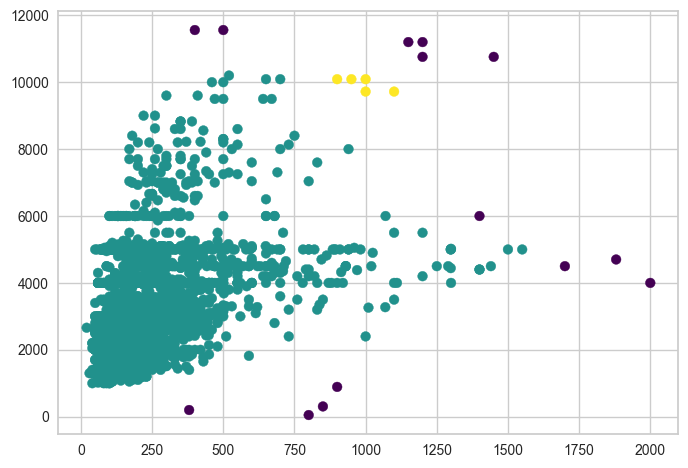

eps= 0.7000000000000001 min_samples= 5
0.6200199466946935


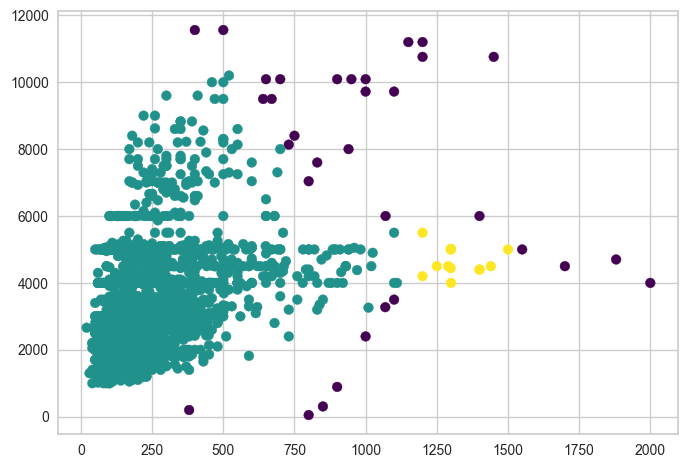

eps= 0.7000000000000001 min_samples= 10
0.14007213541747415


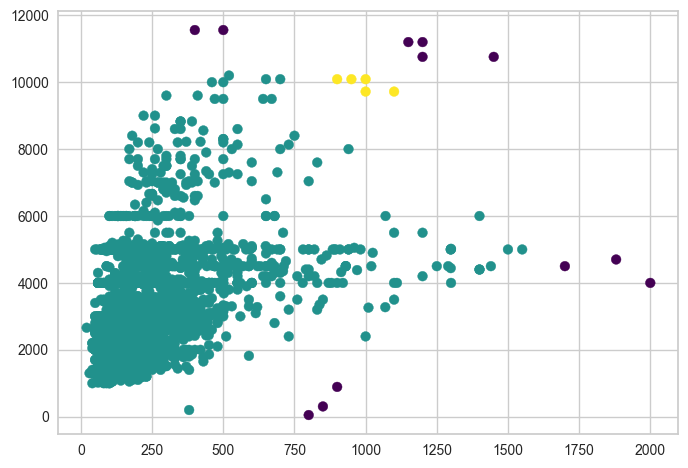

eps= 0.8 min_samples= 5
0.6382285754452424


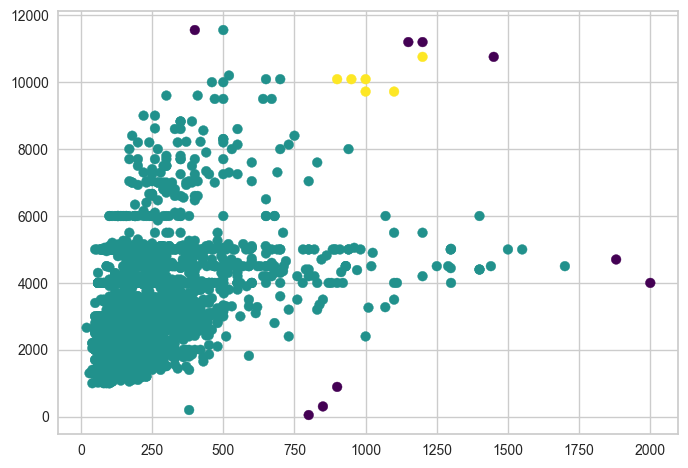

eps= 0.9 min_samples= 5
0.6273535968437759


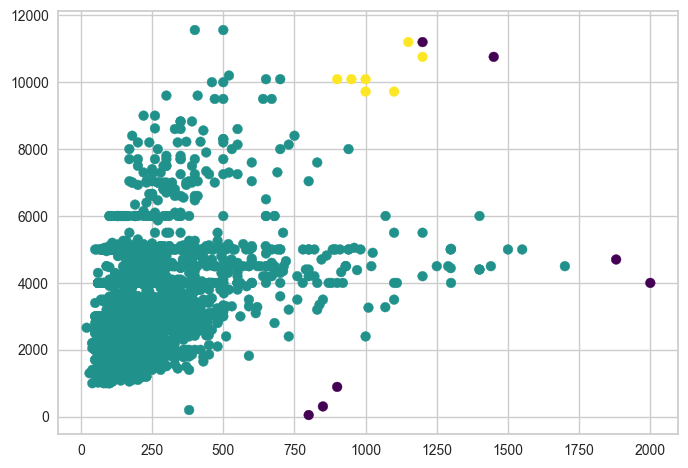

eps= 1.0 min_samples= 5
0.5657408739065344


In [52]:
for i in range (len(list_eps)):
        dbscan = DBSCAN(eps=list_eps[i], min_samples=list_minpt[i])
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        X = df[["Price" , "battery_capacity"]]
        list_labels = list(np.unique(labels))
        plt.scatter(df["Price"] , df["battery_capacity"], c=labels, cmap='viridis')
        plt.show()
        print('eps=',list_eps[i], 'min_samples=',list_minpt[i])
        print(silhouette_score(X ,labels))

## Choosing the best Model based on silhouette_score

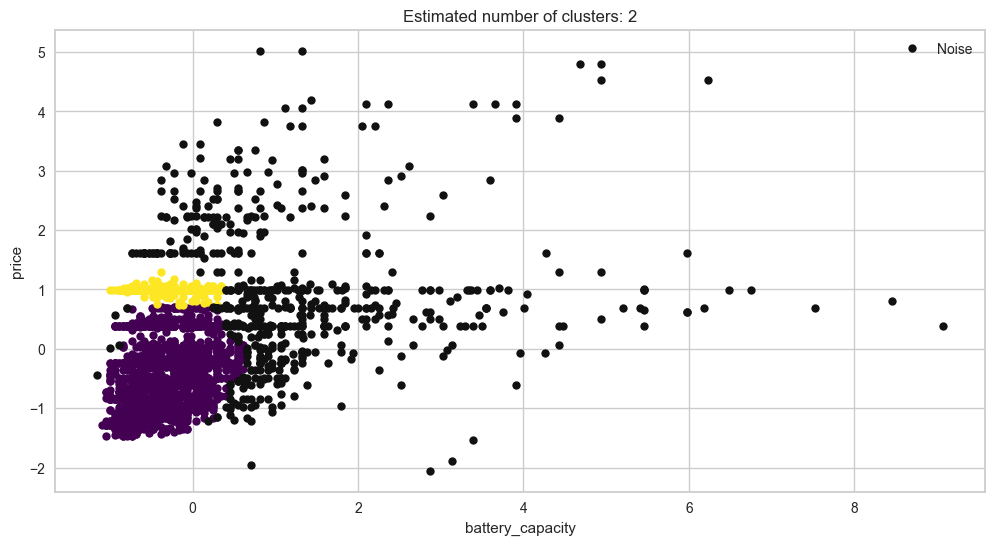

0.3059720108313492


In [53]:
dbscan = DBSCAN(eps=0.2, min_samples=45)
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
df['labels'] = labels
X = df[["Price" , "battery_capacity"]]
cmap = plt.cm.viridis
labels_unique = (df['labels'].unique())
n_clusters_ = len(set(labels_unique)) - (1 if -1 in labels_unique else 0)
labels_unique = labels_unique[labels_unique != -1]  # Exclude noise label for color map
colors = cmap(np.linspace(0, 1, len(labels_unique)))

plt.figure(figsize=(12, 6))

# Plot each cluster
for k, col in zip(labels_unique, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)

    xy = df[['Price_scaled' , 'battery_capacity_scaled']][class_member_mask]
    plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# Noise
xy = df[['Price_scaled' , 'battery_capacity_scaled']][df['labels'] == -1]
plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor='k', markeredgecolor='k', markersize=6, label='Noise')

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('battery_capacity')
plt.ylabel('price')
plt.legend()

plt.show()
print(silhouette_score(X ,labels))

## With droping outliers

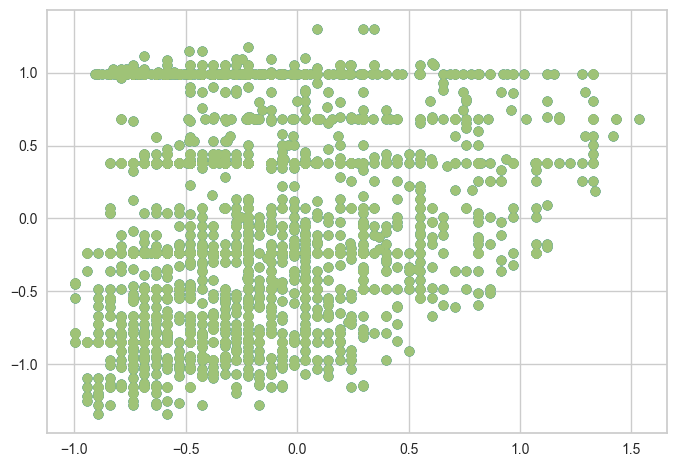

In [54]:
from sklearn.ensemble import IsolationForest
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price' , 'battery_capacity']]
scaler = StandardScaler()
df[['Price_scaled' , 'battery_capacity_scaled']] = scaler.fit_transform(df[['Price' , 'battery_capacity']])
if_ = IsolationForest()
df['is_outlier']= if_.fit_predict(df[['Price' , 'battery_capacity']])
df[['Price_scaled' , 'battery_capacity_scaled']]= df[['Price_scaled' , 'battery_capacity_scaled']].loc[df['is_outlier'] == 1]
df = df.dropna()
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])
plt.scatter(df['Price_scaled'] ,  df['battery_capacity_scaled'])

In [55]:
dbscan = DBSCAN(eps=0.6, min_samples=30)

In [56]:
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
np.unique(labels)

array([0], dtype=int64)

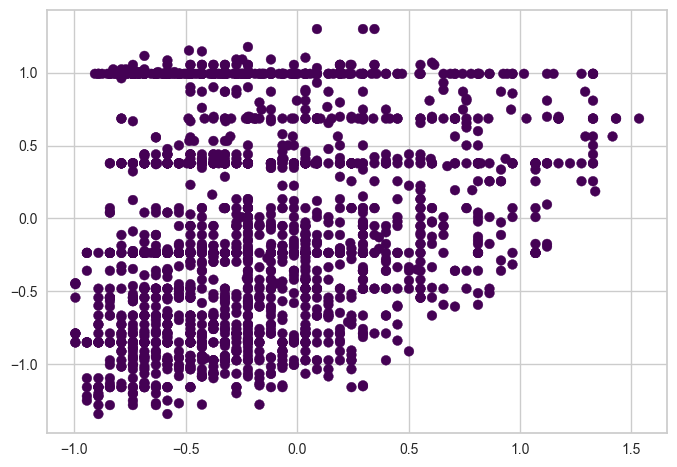

In [57]:
plt.scatter(df["Price_scaled"] , df["battery_capacity_scaled"], c=labels, cmap='viridis')

## Searching in hyperparameters to find possible models that produce three clusters 

In [58]:
list_minpt = []
list_eps = []
for eps in np.arange(0.1,5,0.1).astype(float): 
    for minpt in range (5,60,5):
        dbscan = DBSCAN(eps=eps, min_samples=minpt)
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        list_labels = list(np.unique(labels))
        if len(list_labels) == 3:
            list_eps.append(eps)
            list_minpt.append(minpt)


In [59]:
list_minpt

[55, 40, 45]

In [60]:
list_eps

[0.1, 0.2, 0.2]

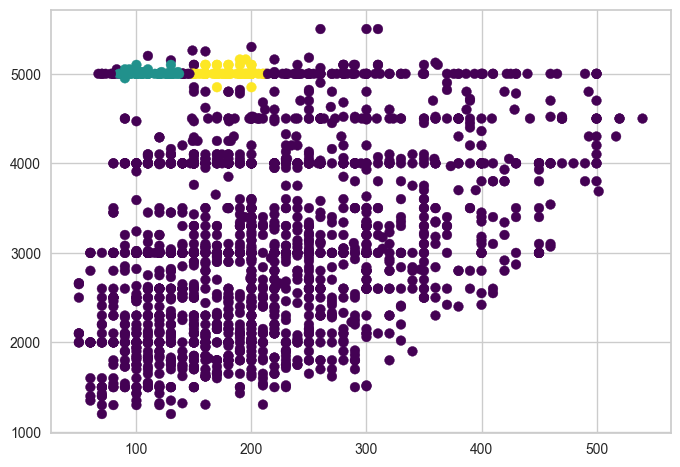

eps= 0.1 min_samples= 55
0.2703920026146091


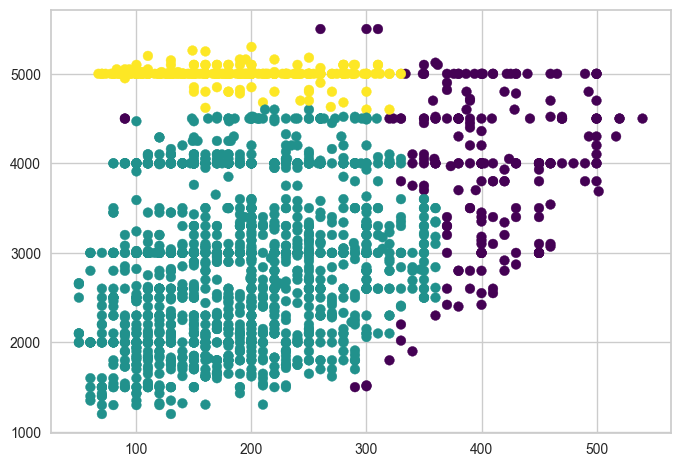

eps= 0.2 min_samples= 40
0.2929383430843098


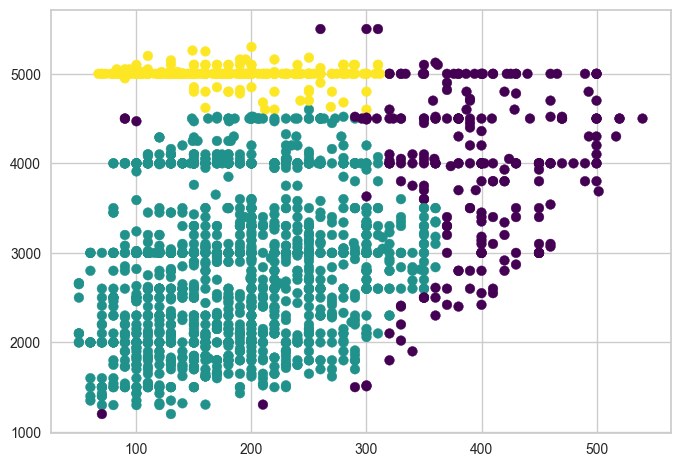

eps= 0.2 min_samples= 45
0.2939085457496128


In [61]:
for i in range (len(list_eps)):
        dbscan = DBSCAN(eps=list_eps[i], min_samples=list_minpt[i])
        labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
        X = df[["Price" , "battery_capacity"]]
        list_labels = list(np.unique(labels))
        plt.scatter(df["Price"] , df["battery_capacity"], c=labels, cmap='viridis')
        plt.show()
        print('eps=',list_eps[i], 'min_samples=',list_minpt[i])
        print(silhouette_score(X ,labels))

## Choosing the best Model based on silhouette_score

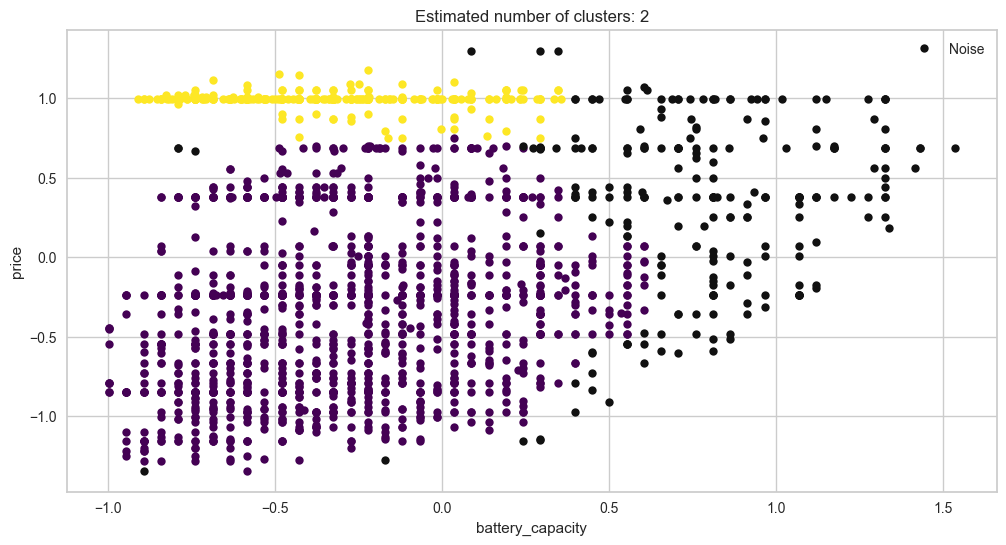

0.2939085457496128


In [62]:
dbscan = DBSCAN(eps=0.2, min_samples=45)
labels = dbscan.fit_predict(df[["Price_scaled" , "battery_capacity_scaled"]])
df['labels'] = labels
X = df[["Price" , "battery_capacity"]]
cmap = plt.cm.viridis
labels_unique = (df['labels'].unique())
n_clusters_ = len(set(labels_unique)) - (1 if -1 in labels_unique else 0)
labels_unique = labels_unique[labels_unique != -1]  # Exclude noise label for color map
colors = cmap(np.linspace(0, 1, len(labels_unique)))

plt.figure(figsize=(12, 6))

# Plot each cluster
for k, col in zip(labels_unique, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)

    xy = df[['Price_scaled' , 'battery_capacity_scaled']][class_member_mask]
    plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# Noise
xy = df[['Price_scaled' , 'battery_capacity_scaled']][df['labels'] == -1]
plt.plot(xy['Price_scaled'], xy['battery_capacity_scaled'], 'o', markerfacecolor='k', markeredgecolor='k', markersize=6, label='Noise')

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('battery_capacity')
plt.ylabel('price')
plt.legend()

plt.show()
print(silhouette_score(X ,labels))


Epsilon (eps)
Definition: eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other. It essentially defines the "reach" of a point in terms of its ability to form a cluster. A smaller eps value means that points need to be closer together to be considered part of the same cluster, leading to a greater number of smaller clusters. Conversely, a larger eps value allows points to be further apart and still be considered part of the same cluster, potentially leading to fewer, larger clusters.

Effect:

Small eps: Can lead to many points being classified as noise if they do not fall within the small neighborhoods. It might result in a higher number of clusters, some of which may be very small.
Large eps: Can cause distant points to be included in the same cluster, which can lead to a smaller number of clusters. However, if eps is too large, it might merge distinct clusters into a single cluster, reducing the granularity of the clustering.
Minimum Samples (min_samples)
Definition: min_samples specifies the number of samples in a neighborhood for a point to be considered as a core point. This parameter reflects the minimum cluster size. Core points are those that have at least min_samples points within their eps neighborhood, including the point itself.

Effect:

Small min_samples: Leads to a lower threshold for a point to be considered as a core point. This can result in a higher number of points being included in clusters, potentially increasing the sensitivity to noise. Clusters may be formed even in less dense regions.
Large min_samples: Increases the density requirement for a cluster. This can result in fewer clusters, as more points might be classified as noise or as part of the border of a cluster rather than as core points. It makes the algorithm more robust to noise, as more points are needed to form a cluster.
Summary
The interplay between eps and min_samples is critical in DBSCAN's clustering process:

A small eps and large min_samples combination can lead to many points being classified as noise, resulting in fewer and possibly more meaningful clusters, but potentially missing smaller clusters.
A large eps and small min_samples combination can lead to overly broad clusters, where distinct groups may be merged into fewer clusters, potentially obscuring meaningful distinctions in the data.
Selecting the appropriate values for eps and min_samples depends on the scale and density of the dataset, as well as the desired granularity of clustering. It often requires experimentation or domain knowledge to find the optimal settings for a given clustering task.


In [ ]:
df4 = df.groupby(['Announced', 'labels']).count().reset_index()
df4['name']
fig = px.bar(df4[['Announced' , 'name' , 'labels' ]], x='Announced', y='name' ,color='labels', title="the number of each cluster per year")
fig.show()

In [ ]:
df5 = df.groupby(['brand', 'labels']).count().reset_index()
fig = px.bar(df5[['name' , 'brand' , 'labels' ]], x='brand', y='name' ,color='labels', title="the number of each cluster per brand")
fig.show()